In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import pandas as pd
from pathlib import Path
import seaborn as sns
import pickle
import numpy as np
import xgboost as xgb
import os

In [2]:
notebook_path = os.path.abspath("train.ipynb")

In [3]:
project_dir = Path(notebook_path).resolve().parents[1]
raw_data_dir = "{}/{}".format(project_dir, "data/raw")
processed_data_dir = "{}/{}".format(project_dir, "data/processed")
model_dir = "{}/{}".format(project_dir, "models")

In [4]:
train_filepath = "{}/{}".format(raw_data_dir, "cs-training.csv")
model_filepath = "{}/{}".format(model_dir, "model.pkl")

In [5]:
df_features = pd.read_csv(train_filepath, index_col=0)

In [6]:
columns = df_features.columns.tolist()
target_column = "SeriousDlqin2yrs"
feature_columns = [column for column in columns if column != target_column]

In [7]:
feature_columns

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

### Split data into training, validation and test datasets

In [8]:
train_idxs = [0, int((80/100) * df_features.shape[0])]
val_idxs = [int((80/100) * df_features.shape[0]), int((90/100) * df_features.shape[0])]
test_idxs = [int((90/100) * df_features.shape[0]), df_features.shape[0]]

In [9]:
df_features["dataset"] = None
col_idx_dataset = df_features.columns.get_loc("dataset")
df_features.iloc[train_idxs[0]:train_idxs[1], col_idx_dataset] = "TRAIN"
df_features.iloc[val_idxs[0]:val_idxs[1], col_idx_dataset] = "VALIDATION"
df_features.iloc[test_idxs[0]:test_idxs[1], col_idx_dataset] = "TEST"

### XGBoost parameters

In [10]:
params_dict = {
    "max_depth": 4,
    "n_estimators": 100,
    "learning_rate": 0.05,
    "n_jobs": -1,
    "objective": "binary:logistic",
    "colsample_bytree": 0.5,
    "gamma": 1
}

In [11]:
def train_model(df,
                target_column,
                feature_columns,
                params_dict):

    df_features = df[df["dataset"] == "TRAIN"]
    df_validation = df[df["dataset"] == "VALIDATION"]

    df_train_X = df_features[feature_columns]
    df_validation_X = df_validation[feature_columns]

    df_train_Y = df_features[target_column]
    df_validation_Y = df_validation[target_column]

    eval_set = [(df_train_X, df_train_Y), (df_validation_X, df_validation_Y)]
    eval_metric = ["auc", "error"]
    scale_pos_weight = df_train_Y[df_train_Y == 0].shape[0] / df_train_Y[df_train_Y == 1].shape[0]

    params_dict["scale_pos_weight"] = scale_pos_weight

    gbm = xgb.XGBClassifier(**params_dict) \
             .fit(X=df_train_X,
                  y=df_train_Y,
                  eval_metric=eval_metric,
                  eval_set=eval_set)

    return gbm

### Train

In [12]:
gbm = train_model(df=df_features, 
                  target_column=target_column, 
                  feature_columns=feature_columns,
                  params_dict=params_dict)

[0]	validation_0-auc:0.79864	validation_0-error:0.18560	validation_1-auc:0.80622	validation_1-error:0.18440
[1]	validation_0-auc:0.84229	validation_0-error:0.20142	validation_1-auc:0.84359	validation_1-error:0.20060
[2]	validation_0-auc:0.84072	validation_0-error:0.18463	validation_1-auc:0.84353	validation_1-error:0.18293
[3]	validation_0-auc:0.85156	validation_0-error:0.18917	validation_1-auc:0.85296	validation_1-error:0.18733
[4]	validation_0-auc:0.85166	validation_0-error:0.17217	validation_1-auc:0.85340	validation_1-error:0.16967
[5]	validation_0-auc:0.84971	validation_0-error:0.17793	validation_1-auc:0.85236	validation_1-error:0.17500
[6]	validation_0-auc:0.85440	validation_0-error:0.16520	validation_1-auc:0.85564	validation_1-error:0.16373
[7]	validation_0-auc:0.85585	validation_0-error:0.16033	validation_1-auc:0.85802	validation_1-error:0.15787
[8]	validation_0-auc:0.85386	validation_0-error:0.16927	validation_1-auc:0.85698	validation_1-error:0.16700
[9]	validation_0-auc:0.85356

[76]	validation_0-auc:0.86696	validation_0-error:0.20473	validation_1-auc:0.86302	validation_1-error:0.20293
[77]	validation_0-auc:0.86702	validation_0-error:0.20424	validation_1-auc:0.86312	validation_1-error:0.20220
[78]	validation_0-auc:0.86709	validation_0-error:0.20458	validation_1-auc:0.86311	validation_1-error:0.20253
[79]	validation_0-auc:0.86721	validation_0-error:0.20417	validation_1-auc:0.86316	validation_1-error:0.20247
[80]	validation_0-auc:0.86727	validation_0-error:0.20381	validation_1-auc:0.86321	validation_1-error:0.20193
[81]	validation_0-auc:0.86736	validation_0-error:0.20363	validation_1-auc:0.86316	validation_1-error:0.20160
[82]	validation_0-auc:0.86748	validation_0-error:0.20415	validation_1-auc:0.86316	validation_1-error:0.20200
[83]	validation_0-auc:0.86756	validation_0-error:0.20442	validation_1-auc:0.86316	validation_1-error:0.20220
[84]	validation_0-auc:0.86766	validation_0-error:0.20495	validation_1-auc:0.86316	validation_1-error:0.20247
[85]	validation_0-a

In [13]:
model_filepath

'/Users/damienmarlier/Documents/foodpanda/foodpanda/models/model.pkl'

In [14]:
pickle.dump(gbm, open(model_filepath, "wb"))

In [15]:
df_train = df_features[df_features["dataset"] == "TRAIN"]
df_val = df_features[df_features["dataset"] == "VALIDATION"]
df_test = df_features[df_features["dataset"] == "TEST"]

### Check prediction distribution across classes

/Users/damienmarlier/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/damienmarlier/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


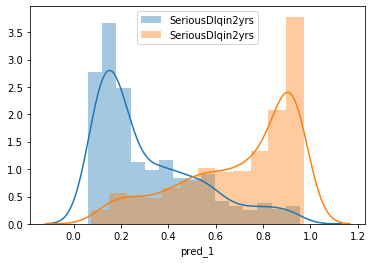

In [16]:
y_train_pred = gbm.predict_proba(df_train.loc[:, feature_columns])
df_train.loc[:, "pred_0"] = y_train_pred[:, 0]
df_train.loc[:, "pred_1"] = y_train_pred[:, 1]
sns.distplot(df_train.loc[df_train[target_column] == 0, :]["pred_1"].sample(n=min(1000, df_test.shape[0])), label=target_column)
sns.distplot(df_train.loc[df_train[target_column] == 1, :]["pred_1"].sample(n=min(1000, df_test.shape[0])), label=target_column)
plt.legend()

In [17]:
df_test[feature_columns]

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
135001,0.292683,58,0,0.366480,3036.0,7,0,1,0,1.0
135002,0.311548,33,1,0.355432,4675.0,11,0,1,0,1.0
135003,0.000000,72,0,0.002166,6000.0,9,0,0,0,0.0
135004,0.279217,45,1,0.489921,6845.0,8,0,2,0,2.0
135005,0.000000,78,0,0.000000,NaN,1,0,0,0,NaN
135006,0.910363,28,0,0.499451,6380.0,8,0,2,0,0.0
135007,0.636596,44,0,0.785457,4166.0,6,0,1,0,0.0
135008,0.141549,26,0,0.268407,4250.0,4,0,0,0,0.0
135009,0.004141,78,0,0.002264,5742.0,7,0,0,0,0.0
135010,1.000000,60,0,120.000000,NaN,2,0,0,0,0.0


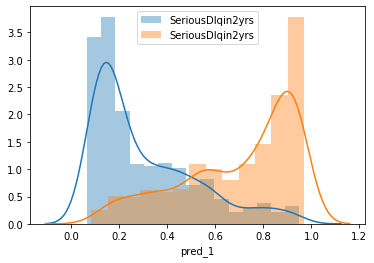

In [18]:
y_test_pred = gbm.predict_proba(df_test[feature_columns])
df_test.loc[:, "pred_0"] = y_test_pred[:, 0]
df_test.loc[:, "pred_1"] = y_test_pred[:, 1]
sns.distplot(df_test.loc[df_test[target_column] == 0, :]["pred_1"].sample(n=min(1000, df_test.shape[0])), label=target_column)
sns.distplot(df_test.loc[df_test[target_column] == 1, :]["pred_1"].sample(n=min(1000, df_test.shape[0])), label=target_column)
plt.legend()

In [19]:
y_true = df_test[target_column].values
y_score = df_test["pred_1"].values
y_pred = df_test["pred_1"].apply(lambda x: 1 if x > 0.5 else 0).values

### Plot confusion matrix

In [20]:
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred)

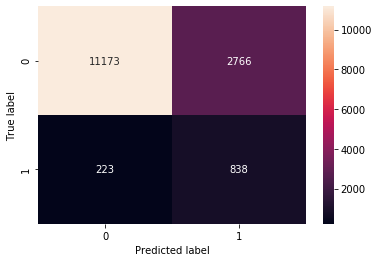

In [21]:
fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt="d")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

### Look at ROC curve

In [22]:
fpr, tpr, roc_thresholds = roc_curve(y_true=y_true,
                                     y_score=y_score)

In [23]:
roc_thresholds

array([1.9692726 , 0.96927255, 0.96526074, ..., 0.06372204, 0.06005003,
       0.05661194], dtype=float32)

Text(0, 0.5, 'TPR')

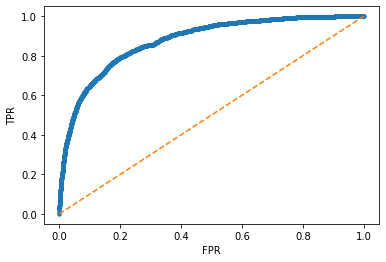

In [24]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

In [25]:
AUC_score = roc_auc_score(y_true=y_true,
                          y_score=y_score)

In [26]:
AUC_score

0.8763378525755041

### Find optimal threshold that maximizes F1-score

In [27]:
precision, recall, pr_thresholds = precision_recall_curve(y_true=y_true,
                                                          probas_pred=y_score,
                                                          pos_label=1)

In [28]:
F1 = 2 * precision * recall / (precision + recall)

Text(0, 0.5, 'F1')

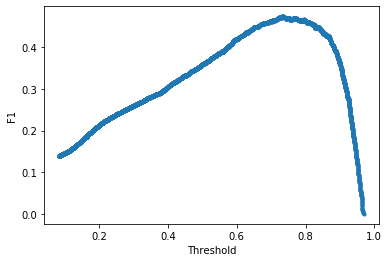

In [29]:
fig, ax = plt.subplots()
plt.plot(pr_thresholds, F1[1:], marker='.')
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")

### Look at feature importance

In [30]:
# ‘weight’: the number of times a feature is used to split the data across all trees.
df_weight = pd.DataFrame([gbm.get_booster().get_score(importance_type='weight')])
df_weight = df_weight.transpose()
df_weight.reset_index(inplace=True)
df_weight.sort_values(by=0, inplace=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

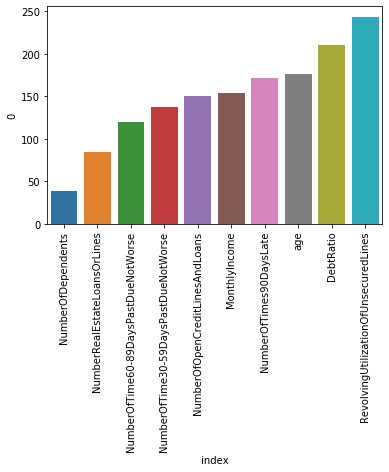

In [31]:
ax = sns.barplot(x="index", y=0, data=df_weight)
degrees = 90
plt.xticks(rotation=degrees)